<a href="https://colab.research.google.com/github/Banafshehkh/C.elegans-Control-Backbone/blob/main/Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Author: Banafsheh Khazali
# Date: June 5, 2023

## ***C.elegans Neuronal Dynamic Simulation***

In [ ]:
import time
import os

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import integrate, signal, sparse, linalg
from threading import Thread
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FuncAnimation, ArtistAnimation
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
""" Number of Neurons """
N = 279

""" Cell membrane conductance (pS) """
Gc = 0.1

""" Cell Membrane Capacitance """
C = 0.015

""" Gap Junctions (Electrical, 279*279) """
ggap = 1.0
Gg_Static = np.load('/content/drive/MyDrive/connectome/Gg.npy')

""" Synaptic connections (Chemical, 279*279) """
gsyn = 1.0
Gs_Static = np.load('/content/drive/MyDrive/connectome/Gs.npy')

""" Leakage potential (mV) """
Ec = -35.0

""" Directionality (279*1) """
E = np.load('/content/drive/MyDrive/connectome/emask.npy')
E = -48.0 * E
EMat = np.tile(np.reshape(E, N), (N, 1))

""" Synaptic Activity Parameters """
ar = 1.0/1.5 # Synaptic activity's rise time
ad = 5.0/1.5 # Synaptic activity's decay time
B = 0.125 # Width of the sigmoid (mv^-1)

""" Input_Mask/Continuous Transtion """
transit_Mat = np.zeros((2, N))

t_Tracker = 0
Iext = 100000

rate = 0.025
offset = 0.15

t_Switch = 0
transit_End = 10


""" Connectome Arrays """
Gg_Dynamic = Gg_Static.copy()
Gs_Dynamic = Gs_Static.copy()

""" Data matrix stack size """
stack_Size = 5000
init_data_Mat = np.zeros((stack_Size + 5000, N))
data_Mat = np.zeros((stack_Size, N))

# """ Directory paths for presets """
# default_Dir = os.getcwd()
# preset_Dir = default_Dir + '/presets'
# save_Dir = default_Dir + '/saved_dynamics'
InMask = np.zeros(N)
oldMask = np.zeros(N)
newMask = np.zeros(N)



In [ ]:

""" Mask transition """
def transit_Mask(input_Array):

    global t_Switch, oldMask, newMask, transit_End, Vth_Static

    transit_Mat[0,:] = transit_Mat[1,:]

    t_Switch = t_Tracker

    transit_Mat[1,:] = input_Array

    oldMask = transit_Mat[0,:]
    newMask = transit_Mat[1,:]

    Vth_Static = EffVth_rhs(Iext, newMask)
    transit_End = t_Switch + 0.3

    print(oldMask, newMask, t_Switch, transit_End)


In [ ]:
def update_Mask(old, new, t, tSwitch):

    return np.multiply(old, 0.5-0.5*np.tanh((t-tSwitch)/rate)) + np.multiply(new, 0.5+0.5*np.tanh((t-tSwitch)/rate))

In [ ]:
""" Ablation """
def modify_Connectome(ablation_Array):

    global Vth_Static, Gg_Dynamic, Gs_Dynamic

    apply_Col = np.tile(ablation_Array, (N, 1))
    apply_Row = np.transpose(apply_Col)

    apply_Mat = np.multiply(apply_Col, apply_Row)

    Gg_Dynamic = np.multiply(Gg_Static, apply_Mat)
    Gs_Dynamic = np.multiply(Gs_Static, apply_Mat)

    try:
        newMask

    except NameError:

        EffVth(Gg_Dynamic, Gs_Dynamic)

        if np.sum(ablation_Array) != N:

            print("Neurons " + str(np.where(ablation_Array == False)[0]) + " are ablated")

        else:

            print("All Neurons healthy")

        print("EffVth Recalculated")

    else:

        EffVth(Gg_Dynamic, Gs_Dynamic)
        Vth_Static = EffVth_rhs(Iext, newMask)

        if np.sum(ablation_Array) != N:

            print("Neurons " + str(np.where(ablation_Array == False)[0]) + " are ablated")

        else:

            print("All Neurons healthy")

        print("EffVth Recalculated")
        print("Vth Recalculated")


In [ ]:
""" Efficient V-threshold computation """
def EffVth(Gg, Gs):

    Gcmat = np.multiply(Gc, np.eye(N))
    EcVec = np.multiply(Ec, np.ones((N, 1)))

    M1 = -Gcmat
    b1 = np.multiply(Gc, EcVec)

    Ggap = np.multiply(ggap, Gg)
    Ggapdiag = np.subtract(Ggap, np.diag(np.diag(Ggap)))
    Ggapsum = Ggapdiag.sum(axis = 1)
    Ggapsummat = sparse.spdiags(Ggapsum, 0, N, N).toarray()
    M2 = -np.subtract(Ggapsummat, Ggapdiag)

    Gs_ij = np.multiply(gsyn, Gs)
    s_eq = round((ar/(ar + 2 * ad)), 4)
    sjmat = np.multiply(s_eq, np.ones((N, N)))
    S_eq = np.multiply(s_eq, np.ones((N, 1)))
    Gsyn = np.multiply(sjmat, Gs_ij)
    Gsyndiag = np.subtract(Gsyn, np.diag(np.diag(Gsyn)))
    Gsynsum = Gsyndiag.sum(axis = 1)
    M3 = -sparse.spdiags(Gsynsum, 0, N, N).toarray()

    b3 = np.dot(Gs_ij, np.multiply(s_eq, E))

    M = M1 + M2 + M3

    global LL, UU, bb

    (P, LL, UU) = linalg.lu(M)
    bbb = -b1 - b3
    bb = np.reshape(bbb, N)


In [ ]:
def EffVth_rhs(Iext, InMask):

    InputMask = np.multiply(Iext, InMask)
    b = np.subtract(bb, InputMask)

    Vth = linalg.solve_triangular(UU, linalg.solve_triangular(LL, b, lower = True, check_finite=False), check_finite=False)

    return Vth


In [ ]:
def voltage_filter(v_vec, vmax, scaler):

    filtered = vmax * np.tanh(scaler * np.divide(v_vec, vmax))

    return filtered

In [ ]:
""" Right hand side """
def membrane_voltageRHS(t, y):
    global InMask, Vth, t_switch, transit_End

    """ Split the incoming values """
    Vvec, SVec = np.split(y, 2)

    """ Gc(Vi - Ec) """
    VsubEc = np.multiply(Gc, (Vvec - Ec))

    """ Gg(Vi - Vj) Computation """
    Vrep = np.tile(Vvec, (N, 1))
    GapCon = np.multiply(Gg_Dynamic, np.subtract(np.transpose(Vrep), Vrep)).sum(axis = 1)

    """ Gs*S*(Vi - Ej) Computation """
    VsubEj = np.subtract(np.transpose(Vrep), EMat)
    SynapCon = np.multiply(np.multiply(Gs_Dynamic, np.tile(SVec, (N, 1))), VsubEj).sum(axis = 1)

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset)
        Vth = EffVth_rhs(Iext, InMask)

    else:

        InMask = newMask
        Vth = Vth_Static

    """ ar*(1-Si)*Sigmoid Computation """
    SynRise = np.multiply(np.multiply(ar, (np.subtract(1.0, SVec))),
                          np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))

    SynDrop = np.multiply(ad, SVec)

    """ Input Mask """
    Input = np.multiply(Iext, InMask)

    """ dV and dS and merge them back to dydt """
    dV = (-(VsubEc + GapCon + SynapCon) + Input)/C
    dS = np.subtract(SynRise, SynDrop)

    return np.concatenate((dV, dS))


In [ ]:
def compute_jacobian(t, y):

    Vvec, SVec = np.split(y, 2)
    Vrep = np.tile(Vvec, (N, 1))

    J1_M1 = -np.multiply(Gc, np.eye(N))
    Ggap = np.multiply(ggap, Gg_Dynamic)
    Ggapsumdiag = -np.diag(Ggap.sum(axis = 1))
    J1_M2 = np.add(Ggap, Ggapsumdiag)
    Gsyn = np.multiply(gsyn, Gs_Dynamic)
    J1_M3 = np.diag(np.dot(-Gsyn, SVec))

    J1 = (J1_M1 + J1_M2 + J1_M3) / C

    J2_M4_2 = np.subtract(EMat, np.transpose(Vrep))
    J2 = np.multiply(Gsyn, J2_M4_2) / C

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset)
        Vth = EffVth_rhs(Iext, InMask)

    else:

        InMask = newMask
        Vth = Vth_Static

    sigmoid_V = np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth))))
    J3_1 = np.multiply(ar, 1 - SVec)
    J3_2 = np.multiply(B, sigmoid_V)
    J3_3 = 1 - sigmoid_V
    J3 = np.diag(np.multiply(np.multiply(J3_1, J3_2), J3_3))

    J4 = np.diag(np.subtract(np.multiply(-ar, sigmoid_V), ad))

    J_row1 = np.hstack((J1, J2))
    J_row2 = np.hstack((J3, J4))
    J = np.vstack((J_row1, J_row2))

    return J


In [ ]:
""" Simulation initiator """
def run_Network(t_Delta, atol):
    dt = t_Delta
    InitCond = 10**(-4)*np.random.normal(0, 0.94, 2*N)

    """ Configuring the ODE Solver """
    r = integrate.ode(membrane_voltageRHS, compute_jacobian).set_integrator('vode', atol=atol, min_step=dt*1e-6, method='bdf')
    r.set_initial_value(InitCond, 0)

    init_data_Mat[0, :] = InitCond[:N]

    session_Data = []
    oldMask = newMask = np.zeros(N)
    t_Switch = 0
    transit_End = 0.3
    k = 1

    while r.successful() and k < stack_Size + 50:
        r.integrate(r.t + dt)
        data = np.subtract(r.y[:N], Vth)
        init_data_Mat[k, :] = voltage_filter(data, 500, 1)
        t_Tracker = r.t
        k += 1

    # emit('new data', init_data_Mat[50:, :].tolist())
    session_Data.append(np.asarray(init_data_Mat[50:, :].tolist()))
    return session_Data

EffVth(Gg_Static, Gs_Static)


In [ ]:
t_Delta = 0.001
atol = 1e-6

#Neuron Stimulation
indices = [276, 278]
value = 9
newMask[indices] = value


simulation_data = run_Network(t_Delta, atol)
simulation_array = np.array(simulation_data[0])
output_file = "simulation_output.npy"
np.save(output_file, simulation_array)


# for second, data in enumerate(simulation_data[0]):
#     print(f"Second {second}:")
#     print(data)
#     print()

<ipython-input-45-dad67b4ae370>:33: RuntimeWarning: overflow encountered in exp
  np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))
<ipython-input-46-549041911109>:30: RuntimeWarning: overflow encountered in exp
  sigmoid_V = np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth))))


In [ ]:
y = np.load("/content/drive/MyDrive/Data/RICR.npy")
y

array([[ 1.24856814e+00,  2.09394646e-02,  7.25893101e-02, ...,
        -1.61318138e-01,  4.98050238e+00,  4.98552681e-02],
       [ 1.16803963e+00,  1.55124179e-02,  5.88152393e-02, ...,
        -1.61980857e-01,  4.70048195e+00,  4.81337814e-02],
       [ 1.09269810e+00,  1.01091173e-02,  4.89046349e-02, ...,
        -1.62629224e-01,  4.43884858e+00,  4.65756292e-02],
       ...,
       [ 2.10320650e-12, -4.88286420e-01,  7.23964675e+00, ...,
        -2.37424536e-01,  1.19334092e+00,  2.16351262e-02],
       [ 2.03215222e-12, -4.88291216e-01,  7.23968949e+00, ...,
        -2.37424864e-01,  1.19334248e+00,  2.16352453e-02],
       [ 1.95399252e-12, -4.88295992e-01,  7.23973205e+00, ...,
        -2.37425191e-01,  1.19334403e+00,  2.16353625e-02]])

In [ ]:
x = pd.DataFrame(y)
neurons = pd.DataFrame(x)
neurons

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,1.248568e+00,0.020939,0.072589,-0.008502,1.853505,1.248569e+00,0.148320,-0.186031,0.627780,-0.080355,...,-0.286292,0.006069,0.027857,-1.141283,0.072933,0.094743,-0.011863,-0.161318,4.980502,0.049855
1,1.168040e+00,0.015512,0.058815,-0.004408,1.772378,1.168041e+00,0.132149,-0.194247,0.590595,-0.085878,...,-0.286551,0.006422,0.026413,-1.101646,0.070146,0.091291,-0.004208,-0.161981,4.700482,0.048134
2,1.092698e+00,0.010109,0.048905,-0.000789,1.695484,1.092699e+00,0.117027,-0.202570,0.555521,-0.091780,...,-0.286873,0.006902,0.025131,-1.062990,0.067563,0.088054,0.002839,-0.162629,4.438849,0.046576
3,1.022220e+00,0.004762,0.042908,0.002390,1.622741,1.022221e+00,0.102927,-0.210955,0.522539,-0.098008,...,-0.287213,0.007498,0.024010,-1.025329,0.065182,0.085031,0.009315,-0.163232,4.194749,0.045184
4,9.562815e-01,-0.000488,0.040336,0.005168,1.553887,9.562825e-01,0.089751,-0.219422,0.491484,-0.104571,...,-0.287614,0.008181,0.023019,-0.988695,0.062970,0.082188,0.015258,-0.163829,3.967159,0.043923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,2.266631e-12,-0.488277,7.239561,-0.064426,0.712456,2.259526e-12,0.032732,-0.236951,0.218694,-0.420042,...,-0.404580,0.025782,0.021469,0.054941,0.025232,0.020275,0.046037,-0.237424,1.193338,0.021635
661,2.188472e-12,-0.488282,7.239604,-0.064426,0.712459,2.181366e-12,0.032732,-0.236948,0.218695,-0.420041,...,-0.404580,0.025782,0.021469,0.054941,0.025233,0.020275,0.046037,-0.237424,1.193339,0.021635
662,2.103206e-12,-0.488286,7.239647,-0.064426,0.712462,2.103206e-12,0.032733,-0.236945,0.218696,-0.420040,...,-0.404581,0.025782,0.021470,0.054941,0.025233,0.020276,0.046037,-0.237425,1.193341,0.021635
663,2.032152e-12,-0.488291,7.239689,-0.064426,0.712464,2.025047e-12,0.032734,-0.236942,0.218697,-0.420039,...,-0.404582,0.025782,0.021470,0.054941,0.025233,0.020276,0.046037,-0.237425,1.193342,0.021635


In [ ]:
# read neuron names from a txt file and then change the column names
neurons['time']=pd.Index(pd.Index(range(0,neurons.shape[0], 1)), append=True)
neurons.set_index('time',inplace=True)



# read the txt file including neuron names
with open('/content/drive/MyDrive/connectome/neuron_names.txt') as f:
    ncolumns = f.readlines()
rep = []
for x in ncolumns:
    new_list = rep.append(x.replace(",\n", ""))
print(list(rep))



# remove \n, "" , '', redundant []
new = []
for x in list(rep):
    new.append(x.replace("u", ""))
# print((new))



nlc = []
for x in list(new):
    nlc.append(x.replace("'", ""))
# print((nlc))

nlc1 = []
for x in list(nlc):
    nlc1.append(x.replace(" ", ""))
# print((nlc1))



nlc2 = []
for x in list(nlc1):
    nlc2.append(x.replace("[", ""))
# print((nlc2))


nlc3 = []
for x in list(nlc2):
    nlc3.append(x.replace("]", ""))
# print((nlc3))


nlc4 = []
for x in list(nlc3):
    nlc4.append(x.replace("\n", ""))
# print((nlc4))


neurons.columns = nlc4

neurons.head()

["[u'IL2DL'", " u'IL2VL'", " u'IL2L'", " u'URADL'", " u'IL1VL'", " u'IL2DR'", " u'IL1DL'", " u'OLLL'", " u'IL1L'", " u'URYDL'", " u'OLQDL'", " u'URYDR'", " u'IL2R'", " u'URYVL'", " u'RIPL'", " u'OLLR'", " u'URBL'", " u'IL2VR'", " u'IL1DR'", " u'URADR'", " u'IL1R'", " u'URAVL'", " u'OLQVL'", " u'RMED'", " u'URBR'", " u'OLQDR'", " u'URYVR'", " u'RIPR'", " u'RMEL'", " u'BAGL'", " u'CEPVL'", " u'BAGR'", " u'OLQVR'", " u'URAVR'", " u'RMER'", " u'IL1VR'", " u'RID'", " u'CEPVR'", " u'RMEV'", " u'CEPDL'", " u'RMDVL'", " u'SAAVL'", " u'SMDVL'", " u'URXL'", " u'ALA'", " u'RMDVR'", " u'CEPDR'", " u'AVAL'", " u'RIAL'", " u'ASKL'", " u'SAAVR'", " u'RMDL'", " u'URXR'", " u'SMDVR'", " u'AFDL'", " u'AVAR'", " u'RIAR'", " u'ASKR'", " u'AVEL'", " u'ADLL'", " u'ADFL'", " u'RMDR'", " u'AFDR'", " u'SIBDL'", " u'RIH'", " u'AWBL'", " u'AVER'", " u'RMDDL'", " u'AWCL'", " u'ADFR'", " u'ASGL'", " u'SAADL'", " u'ADLR'", " u'AWAL'", " u'AWBR'", " u'ASIL'", " u'ASHL'", " u'SIBDR'", " u'ASGR'", " u'AIBL'", " u'ASHR

<ipython-input-56-6133401fd9ca>:2: FutureWarning: Passing keywords other than 'data', 'dtype', 'copy', 'name', 'tupleize_cols' is deprecated and will raise TypeError in a future version.  Use the specific Index subclass directly instead.
  neurons['time']=pd.Index(pd.Index(range(0,neurons.shape[0], 1)), append=True)


,IL2DL,IL2VL,IL2L,URADL,IL1VL,IL2DR,IL1DL,OLLL,IL1L,URYDL,...,PVR,PVWL,PVWR,PLNL,PHCR,PHCL,PVNR,PLMR,PVNL,PLML
time,,,,,,,,,,,,,,,,,,,,,
0,1.248568,0.020939,0.072589,-0.008502,1.853505,1.248569,0.148320,-0.186031,0.627780,-0.080355,...,-0.286292,0.006069,0.027857,-1.141283,0.072933,0.094743,-0.011863,-0.161318,4.980502,0.049855
1,1.168040,0.015512,0.058815,-0.004408,1.772378,1.168041,0.132149,-0.194247,0.590595,-0.085878,...,-0.286551,0.006422,0.026413,-1.101646,0.070146,0.091291,-0.004208,-0.161981,4.700482,0.048134
2,1.092698,0.010109,0.048905,-0.000789,1.695484,1.092699,0.117027,-0.202570,0.555521,-0.091780,...,-0.286873,0.006902,0.025131,-1.062990,0.067563,0.088054,0.002839,-0.162629,4.438849,0.046576
3,1.022220,0.004762,0.042908,0.002390,1.622741,1.022221,0.102927,-0.210955,0.522539,-0.098008,...,-0.287213,0.007498,0.024010,-1.025329,0.065182,0.085031,0.009315,-0.163232,4.194749,0.045184
4,0.956282,-0.000488,0.040336,0.005168,1.553887,0.956282,0.089751,-0.219422,0.491484,-0.104571,...,-0.287614,0.008181,0.023019,-0.988695,0.062970,0.082188,0.015258,-0.163829,3.967159,0.043923


<Axes: xlabel='time'>

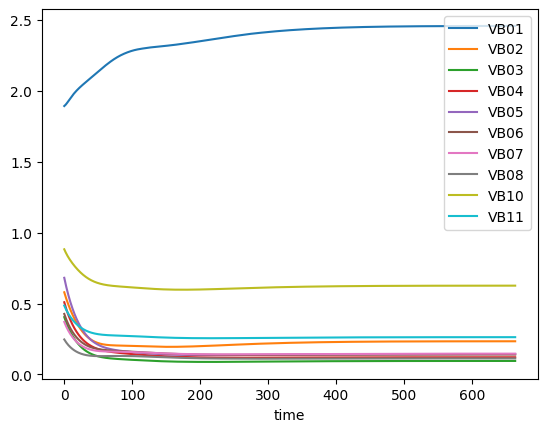

In [ ]:
# VD
VD = neurons[['VB01', 'VB02', 'VB03', 'VB04', 'VB05', 'VB06', 'VB07', 'VB08',  'VB10', 'VB11']]
VD_new = VD[(neurons.index < 5000) ]
VD_new.plot()

<Axes: xlabel='time'>

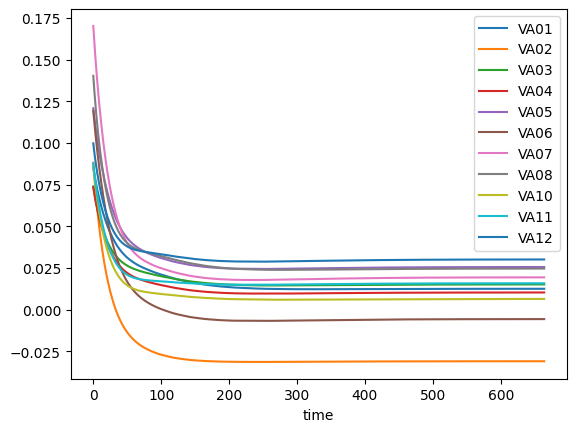

In [ ]:
# VA
VA = neurons[['VA01', 'VA02', 'VA03', 'VA04', 'VA05', 'VA06', 'VA07', 'VA08',  'VA10', 'VA11', 'VA12']]
VA_new = VA[(neurons.index < 5000) ]
VA_transpose = VA_new.transpose()
VA_new.plot()

<Axes: xlabel='time'>

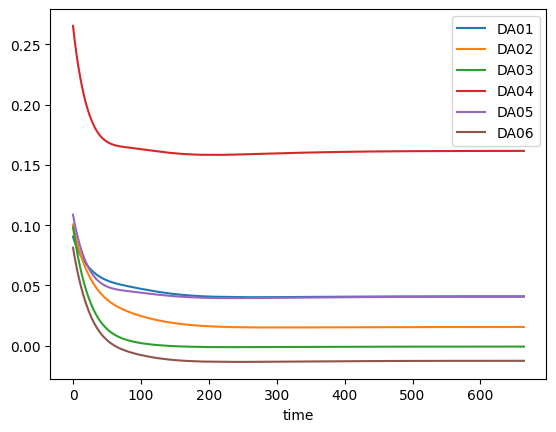

In [ ]:
# DA
DA = neurons[['DA01', 'DA02', 'DA03', 'DA04', 'DA05', 'DA06']]
DA_new = DA[(neurons.index < 5000) ]
DA_new.plot()

<Axes: xlabel='time'>

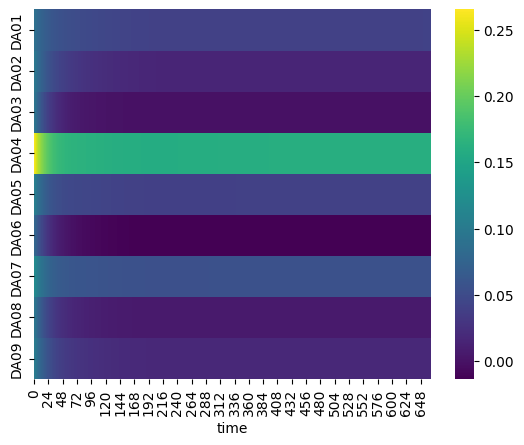

In [ ]:
# DA
DA = neurons[['DA01', 'DA02', 'DA03', 'DA04', 'DA05', 'DA06', 'DA07', 'DA08', 'DA09']]
DA_new = DA[(neurons.index < 5000)]
DA_transpose = DA_new.transpose()
sns.heatmap(DA_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

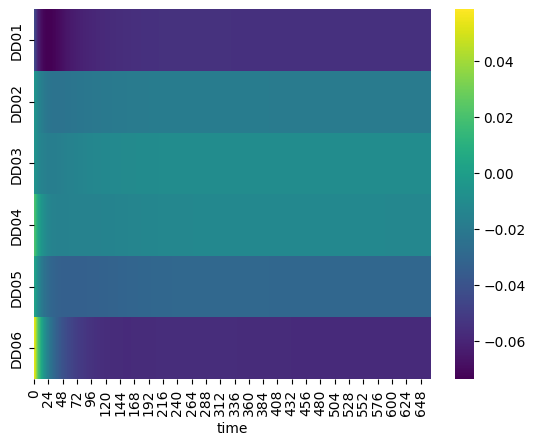

In [ ]:
# DD
DD = neurons[['DD01', 'DD02', 'DD03', 'DD04', 'DD05', 'DD06']]
DD_new = DD[(neurons.index < 5000)]
DD_transpose = DD_new.transpose()
sns.heatmap(DD_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

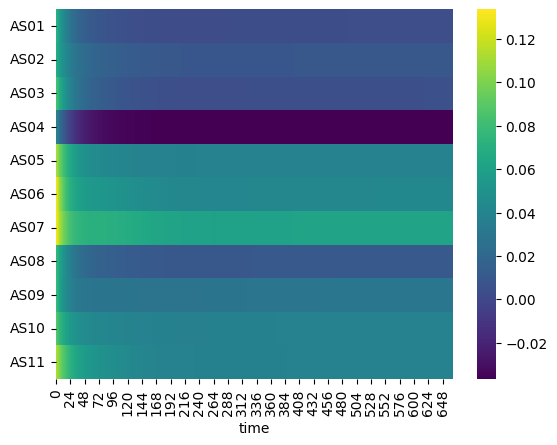

In [ ]:
# AS
AS = neurons[['AS01', 'AS02', 'AS03', 'AS04', 'AS05', 'AS06', 'AS07', 'AS08', 'AS09', 'AS10', 'AS11']]
AS_new = AS[(neurons.index <5000 )]
AS_transpose = AS_new.transpose()
sns.heatmap(AS_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

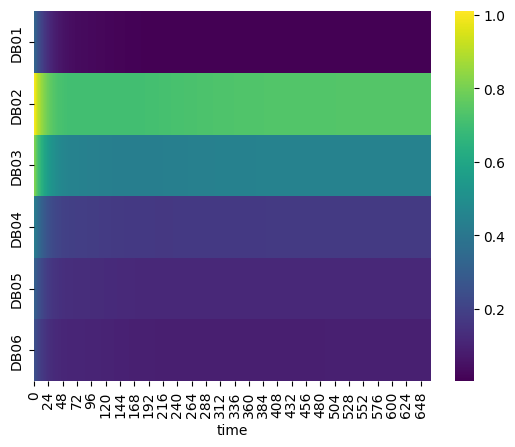

In [ ]:
# DB
DB= neurons[['DB01', 'DB02', 'DB03', 'DB04', 'DB05', 'DB06']]
DB_new = DB[(neurons.index < 5000)]
DB_transpose = DB_new.transpose()
sns.heatmap(DB_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

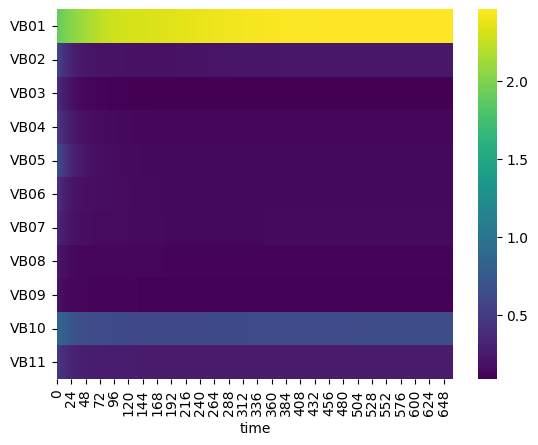

In [ ]:
# VB
VB= neurons[['VB01', 'VB02', 'VB03', 'VB04', 'VB05', 'VB06', 'VB07', 'VB08', 'VB09', 'VB10', 'VB11']]
VB_new = VB[(neurons.index < 5000 )]
VB_transpose = VB_new.transpose()
sns.heatmap(VB_transpose, cmap = 'viridis')

<Axes: xlabel='time'>

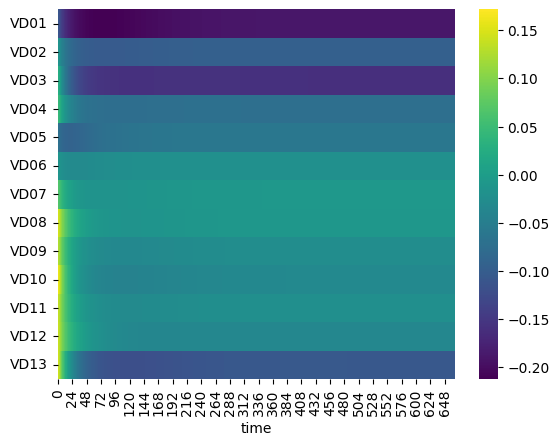

In [ ]:
# VD
VD= neurons[['VD01', 'VD02', 'VD03', 'VD04', 'VD05', 'VD06', 'VD07', 'VD08', 'VD09', 'VD10', 'VD11', 'VD12', 'VD13']]
VD_new = VD[(neurons.index < 5000)]
VD_transpose = VD_new.transpose()
sns.heatmap(VD_transpose, cmap = 'viridis')

Text(50.722222222222214, 0.5, 'VA')

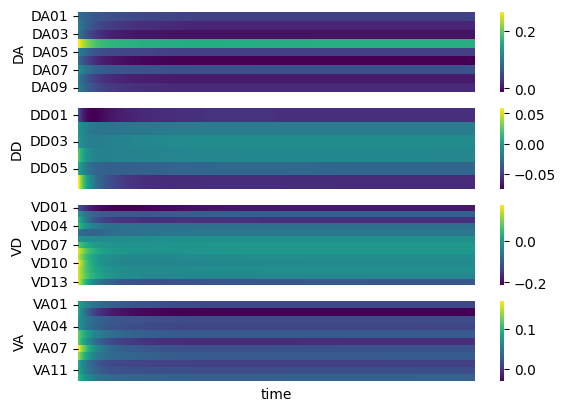

In [ ]:
import matplotlib.pyplot as plt
# plot all figures in one
f,(ax1,ax2,ax3, ax4) = plt.subplots(4,1)

g1 = sns.heatmap(DA_transpose,cmap = 'viridis',ax=ax1, xticklabels=False)
g1.set_ylabel('DA')
g1.set_xlabel('')
g2 = sns.heatmap(DD_transpose, cmap = 'viridis',ax=ax2, xticklabels=False)
g2.set_ylabel('DD')
g2.set_xlabel('')
g3 = sns.heatmap(VD_transpose, cmap='viridis',ax=ax3, xticklabels=False)
g3.set_ylabel('VD')
g3.set_xlabel('')
g4 = sns.heatmap(VA_transpose, cmap = 'viridis',ax=ax4, xticklabels=False)
g4.set_ylabel('VA')



Text(50.722222222222214, 0.5, 'VA')

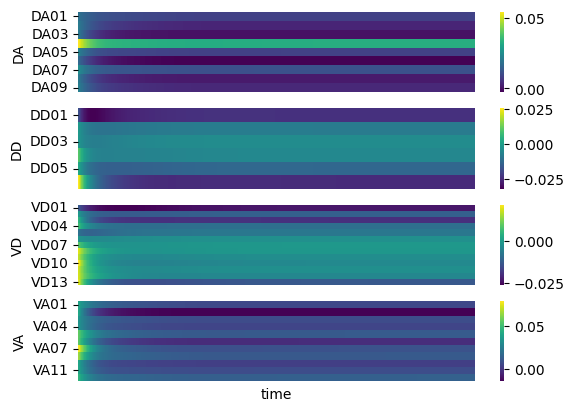

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# normalize the data
DA_transpose_norm = np.linalg.norm(DA_transpose)
DD_transpose_norm = np.linalg.norm(DD_transpose)
VD_transpose_norm = np.linalg.norm(VD_transpose)
VA_transpose_norm = np.linalg.norm(VA_transpose)

DA_transpose_normalized = DA_transpose / DA_transpose_norm
DD_transpose_normalized = DD_transpose / DD_transpose_norm
VD_transpose_normalized = VD_transpose / VD_transpose_norm
VA_transpose_normalized = VA_transpose / VA_transpose_norm

# plot all figures in one
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)

g1 = sns.heatmap(DA_transpose_normalized, cmap='viridis', ax=ax1, xticklabels=False)
g1.set_ylabel('DA')
g1.set_xlabel('')
g2 = sns.heatmap(DD_transpose_normalized, cmap='viridis', ax=ax2, xticklabels=False)
g2.set_ylabel('DD')
g2.set_xlabel('')
g3 = sns.heatmap(VD_transpose_normalized, cmap='viridis', ax=ax3, xticklabels=False)
g3.set_ylabel('VD')
g3.set_xlabel('')
g4 = sns.heatmap(VA_transpose_normalized, cmap='viridis', ax=ax4, xticklabels=False)
g4.set_ylabel('VA')


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: 

Text(50.722222222222214, 0.5, 'VA')

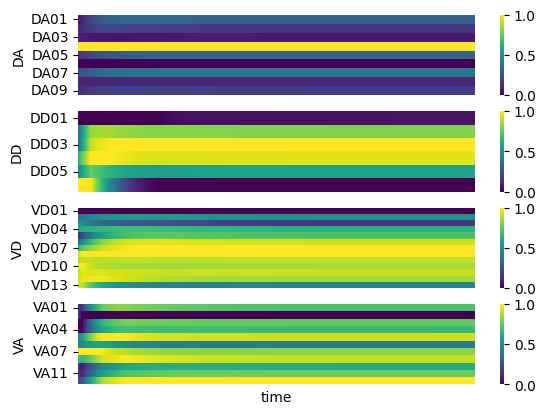

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# normalize the data
DA_transpose_min = np.min(DA_transpose)
DA_transpose_max = np.max(DA_transpose)
DA_transpose_normalized = (DA_transpose - DA_transpose_min) / (DA_transpose_max - DA_transpose_min)

DD_transpose_min = np.min(DD_transpose)
DD_transpose_max = np.max(DD_transpose)
DD_transpose_normalized = (DD_transpose - DD_transpose_min) / (DD_transpose_max - DD_transpose_min)

VD_transpose_min = np.min(VD_transpose)
VD_transpose_max = np.max(VD_transpose)
VD_transpose_normalized = (VD_transpose - VD_transpose_min) / (VD_transpose_max - VD_transpose_min)

VA_transpose_min = np.min(VA_transpose)
VA_transpose_max = np.max(VA_transpose)
VA_transpose_normalized = (VA_transpose - VA_transpose_min) / (VA_transpose_max - VA_transpose_min)

# plot all figures in one
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)

g1 = sns.heatmap(DA_transpose_normalized, cmap='viridis', ax=ax1, xticklabels=False)
g1.set_ylabel('DA')
g1.set_xlabel('')
g2 = sns.heatmap(DD_transpose_normalized, cmap='viridis', ax=ax2, xticklabels=False)
g2.set_ylabel('DD')
g2.set_xlabel('')
g3 = sns.heatmap(VD_transpose_normalized, cmap='viridis', ax=ax3, xticklabels=False)
g3.set_ylabel('VD')
g3.set_xlabel('')
g4 = sns.heatmap(VA_transpose_normalized, cmap='viridis', ax=ax4, xticklabels=False)
g4.set_ylabel('VA')


Text(50.722222222222214, 0.5, 'VD')

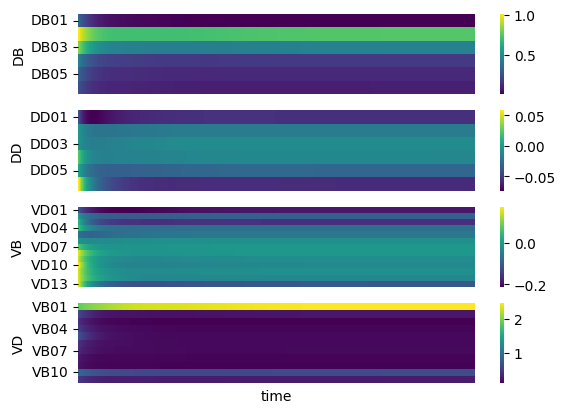

In [ ]:
import matplotlib.pyplot as plt
# plot all figures in one
f,(ax1,ax2,ax3, ax4) = plt.subplots(4,1)

g1 = sns.heatmap(DB_transpose,cmap = 'viridis',ax=ax1, xticklabels=False)
g1.set_ylabel('DB')
g1.set_xlabel('')
g2 = sns.heatmap(DD_transpose, cmap = 'viridis',ax=ax2, xticklabels=False)
g2.set_ylabel('DD')
g2.set_xlabel('')
g3 = sns.heatmap(VD_transpose, cmap='viridis',ax=ax3, xticklabels=False)
g3.set_ylabel('VB')
g3.set_xlabel('')
g4 = sns.heatmap(VB_transpose, cmap = 'viridis',ax=ax4, xticklabels=False)
g4.set_ylabel('VD')


In [ ]:
# Load the simulation output data
simulation_data = np.load("/content/simulation_output.npy")
simulation_data = simulation_data[:5000, :]


fig, ax = plt.subplots()

# Create scatter points for each neuron
scatters = []
for neuron in range(279):
    scatter = ax.scatter([], [], label=f"Neuron {neuron+1}")
    scatters.append(scatter)

# Set the x and y limits of the plot
ax.set_xlim(0, simulation_data.shape[0])  # Number of time steps
ax.set_ylim(-100, 100)  # Voltage range

ax.set_xlabel("Time Step")
ax.set_ylabel("Voltage")
ax.set_title("Neuronal Activity")

# Create a function to update the plot with new data
def update_plot(frame):
    for neuron, scatter in enumerate(scatters):
        scatter.set_offsets(np.column_stack((range(simulation_data.shape[0]), simulation_data[:, neuron])))
        scatter.set_array(simulation_data[:, neuron])  # Set the color based on voltage
    # ax.legend()
    return scatters

frames = []
for frame in range(simulation_data.shape[1]):
    update_plot(frame)
    frames.append([scatter for scatter in scatters])

animation = ArtistAnimation(fig, frames)

plt.show()



FileNotFoundError: ignored

In [ ]:
# import numpy as np
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Load the simulation output data
# simulation_data = np.load("/content/simulation_output.npy")

# # Select the first 5000 time steps
# simulation_data = simulation_data[:100, :]

# # Create the figure and subplot for the plot
# fig = make_subplots(rows=1, cols=1)
# fig.update_layout(
#     xaxis=dict(title="Time Step"),
#     yaxis=dict(title="Voltage"),
#     title="Neuronal Activity"
# )

# # Create the scatter traces for each neuron
# traces = []
# for neuron in range(279):
#     trace = go.Scatter(
#         x=np.arange(simulation_data.shape[0]),
#         y=simulation_data[:, neuron],
#         mode="markers",
#         marker=dict(
#             size=4,
#             color=simulation_data[:, neuron],
#             colorscale="Viridis",
#             showscale=False
#         ),
#         name=f"Neuron {neuron+1}"
#     )
#     traces.append(trace)

# # Add the traces to the figure
# for trace in traces:
#     fig.add_trace(trace)

# # Create the animation frames
# frames = []
# for frame in range(simulation_data.shape[0]):
#     frames.append(go.Frame(data=[go.Scatter(x=np.arange(frame+1), y=simulation_data[:frame+1, neuron]) for neuron in range(279)]))

# # Add the frames to the animation
# fig.frames = frames

# # Update the layout to include animation settings
# fig.update_layout(
#     updatemenus=[dict(
#         type="buttons",
#         buttons=[dict(label="Play", method="animate", args=[None, {"frame": {"duration": 50, "redraw": True}, "fromcurrent": True, "transition": {"duration": 0}}])],
#         showactive=False,
#     )]
# )

# # Show the plot
# fig.show()
